# Homework 8

This week, our task was to use an autoencoder to denoise or resconstruct images form the MINST dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

We did not use the TFDS version of the MNIST, but instead the one from keras. This was easier to implement, since the data is given in numpy arrays and didnt have to be transformed first, but could be transformed back to a tensor easily. 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def add_noise(img, random_chance=10):
    noisy = []
    for row in img:
        new_row = []
        for pix in row:
            if random.choice(range(100)) <= random_chance:
                new_val = random.uniform(0,1)
                new_row.append(new_val)
            else:
                new_row.append(pix)
        noisy.append(new_row)
    return np.array(noisy)

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_test.shape

(10000, 28, 28)

Here we can see the results of the noise function.

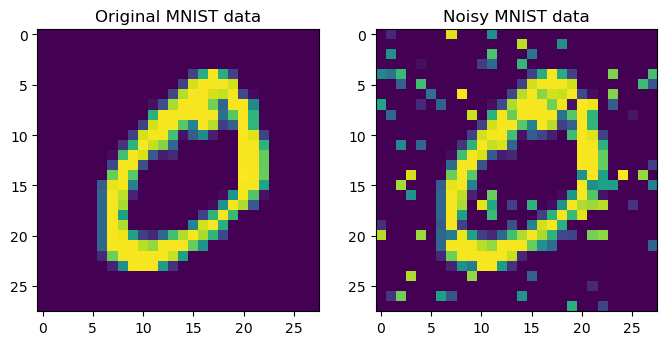

In [5]:
plt.figure(figsize=(8,5), dpi = 100)
plt.subplot(1,2,1)
plt.imshow(x_train[1])
plt.title('Original MNIST data')
plt.subplot(1,2,2)
plt.imshow(add_noise(x_train[1]/255.0))
plt.title('Noisy MNIST data')
plt.show()

## Preprocessing

In [7]:
def preprocessing(data):

    # Normalize the images
    data = data/255.0

    # Add noise to the images
    noisy = [add_noise(x, random_chance=10) for x in data]

    # Add the noisy images to the dataset
    dataset = (noisy, data)

    # Convert to tensorflow slices
    dataset = tf.data.Dataset.from_tensor_slices(dataset)

    # Apply correct dtype
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

    # Expand dimensions
    dataset = dataset.map(lambda x, y: (tf.expand_dims(x, -1), tf.expand_dims(y, -1)))

    # Cache progress
    dataset = dataset.cache()

    # Shuffle the dataset
    dataset = dataset.shuffle(1024)

    # Batch the dataset
    dataset = dataset.batch(32)

    # Prefetch the dataset
    dataset = dataset.prefetch(20)

    return dataset

train_preprocessed = preprocessing(x_train)
test_preprocessed = preprocessing(x_test)

After preprocessing, our samples are converted to tensors and look like this:

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))


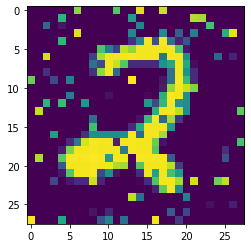

In [8]:
print(train_preprocessed.element_spec)
plt.imshow(train_preprocessed.as_numpy_iterator().next()[0][0])

__________

## Model

We first implemented a subclass model, but initialized it with keras (compile, build). This was shown to somehow give a better performance than the entire subclass model without API.

In [9]:
class tf_autoencoder(tf.keras.Model):
    """ Autoencoder Network """
    def __init__(self):
        super(tf_autoencoder, self).__init__()

        self.encoder_layers = [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='valid', activation='relu'),
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='valid', activation='relu'),
            tf.keras.layers.Flatten(name='encoder_flatten'),
            tf.keras.layers.Dense(units=8, name='encoder_dense')
        ]
        
        self.decoder_layers = [
            tf.keras.layers.InputLayer(input_shape=(8,)),
            tf.keras.layers.Dense(units=2*2*32, activation='relu', name='decoder_dense'),
            tf.keras.layers.Reshape(target_shape=(2, 2, 32)),
            tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=1, kernel_size=9, strides=1, padding='valid', activation='sigmoid')
        ]
    
    def encoder(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        return x

    def decoder(self, x):
        for layer in self.decoder_layers:
            x = layer(x)
        return x

    @tf.function
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x


In [10]:
ae = tf_autoencoder()

ae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

In [11]:
history1 = ae.fit(train_preprocessed, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0880 - accuracy: 0.8074
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0648 - accuracy: 0.8086
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0512 - accuracy: 0.8001
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0416 - accuracy: 0.7986
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0371 - accuracy: 0.8006
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0348 - accuracy: 0.8015
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0333 - accuracy: 0.8020
Epoch 8/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0321 - accuracy: 0.8024
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0312 - accuracy: 0.8028
Epoch 10/10
1875/1875 [==============================] - 17s 9ms/step - l

In [12]:
history2 = ae.fit(test_preprocessed, epochs=10)

Epoch 1/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0297 - accuracy: 0.8026
Epoch 2/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0296 - accuracy: 0.8026
Epoch 3/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0295 - accuracy: 0.8026
Epoch 4/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0293 - accuracy: 0.8027
Epoch 5/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0292 - accuracy: 0.8027
Epoch 6/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0291 - accuracy: 0.8028
Epoch 7/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0290 - accuracy: 0.8028
Epoch 8/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0290 - accuracy: 0.8028
Epoch 9/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0289 - accuracy: 0.8029
Epoch 10/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0288 - accuracy: 0.8030

In [13]:
ae.evaluate(test_preprocessed)

313/313 [==============================] - 1s 3ms/step - loss: 0.0288 - accuracy: 0.8029


[0.02879178337752819, 0.802913248538971]

Final accuarcy was around 80% with this model.

In [17]:
class autoencoder(tf.keras.Model):
    """ Autoencoder Network """
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder_layers = [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='valid', activation='relu'),
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='valid', activation='relu'),
            tf.keras.layers.Flatten(name='encoder_flatten'),
            tf.keras.layers.Dense(units=8, name='encoder_dense')
        ]
        
        self.decoder_layers = [
            tf.keras.layers.InputLayer(input_shape=(8,)),
            tf.keras.layers.Dense(units=2*2*32, activation='relu', name='decoder_dense'),
            tf.keras.layers.Reshape(target_shape=(2, 2, 32)),
            tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=3, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters=1, kernel_size=9, strides=1, padding='valid', activation='sigmoid')
        ]
    
    def encoder(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        return x

    def decoder(self, x):
        for layer in self.decoder_layers:
            x = layer(x)
        return x

    @tf.function
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

    def training_step(self, input, target, loss_function, optimizer):
            with tf.GradientTape() as tape:
                prediction = self.call(input)
                loss = loss_function(target, prediction)
                gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            return loss

    def test(self, test_data, loss_function):
        # test over complete test data
        accuracy_aggregator = []
        loss_aggregator = []

        for (input, target) in test_data:
            prediction = self.call(input)
            sample_test_loss = loss_function(target, prediction)
            sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
            sample_test_accuracy = np.mean(sample_test_accuracy)
            loss_aggregator.append(sample_test_loss.numpy())
            accuracy_aggregator.append(np.mean(sample_test_accuracy))

        loss = tf.reduce_mean(loss_aggregator)
        accuracy = tf.reduce_mean(accuracy_aggregator)

        return loss, accuracy

    def train(self, epochs):
        tf.keras.backend.clear_session()
        
        loss = tf.keras.losses.MeanSquaredError()
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        accuracies = []
        losses = []
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        # Test runthrough
        test_loss, test_accuracy = self.test(test_preprocessed, loss)

        accuracies.append(test_accuracy)
        losses.append(test_loss)

        # Train runthrough
        train_loss, train_accuracy = self.test(train_preprocessed, loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        """ # Validation runthrough
        val_loss, val_accuracy = self.test(val_preprocessed, loss)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy) """

        print('Initial loss:', test_loss.numpy(), 'Initial accuracy:', test_accuracy.numpy(),'\n')

        for epoch in range(epochs):
            print(f'Epoch: {epoch}, accuracy of {accuracies[-1]}')

            epoch_loss = []

            for (input, target) in train_preprocessed:
                loss_value = self.training_step(input, target, loss, optimizer)
                epoch_loss.append(loss_value)

            train_losses.append(tf.reduce_mean(epoch_loss))
            train_accuracies.append(self.test(train_preprocessed, loss)[1])

            """ val_loss, val_accuracy = self.test(val_preprocessed, loss)
            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss) """

            test_loss, test_accuracy = self.test(test_preprocessed, loss)
            accuracies.append(test_accuracy)
            losses.append(test_loss)

        print('\nFinal (test) accuracy:', test_accuracy.numpy(),'\n')

        return accuracies, losses, train_accuracies, train_losses#, val_accuracies, val_losses

In [18]:
autoen = autoencoder()

test_accuracies, test_losses, train_accuracies, train_losses = autoen.train(epochs=10)

Initial loss: 0.23143838 Initial accuracy: 0.02188284459151073 

Epoch: 0, accuracy of 0.02188284459151073
Epoch: 1, accuracy of 0.19338700935645828
Epoch: 2, accuracy of 0.11538324395253308
Epoch: 3, accuracy of 0.11222044728434508
Epoch: 4, accuracy of 0.10958894340483799
Epoch: 5, accuracy of 0.11397121748060247
Epoch: 6, accuracy of 0.11874572113190324
Epoch: 7, accuracy of 0.12043230830670927
Epoch: 8, accuracy of 0.12399446599726152
Epoch: 9, accuracy of 0.12313156093108168

Final (test) accuracy: 0.12296040620721131 



This model somehow learned really slow, altough using the same parameters (adam with lr=0.001, same loss function). It seems like it would converge to a solution but took too long, so we capped it at 10 epochs. 

______

## Results

### T-SNE

Here, we show the results of the t-SNE algorithm on the embedded images using the subclass-mix model.

1.0.1
Test Set: (10000, 28, 28)
Expand dims, first 1000: (1000, 28, 28, 1)
After embeddings (1000, 8)


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


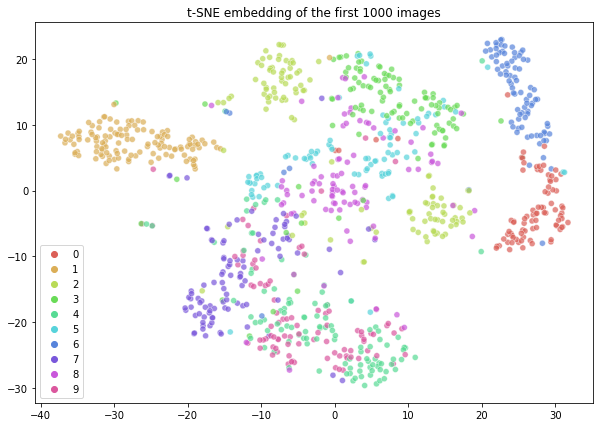

In [14]:
import sklearn
from sklearn.manifold import TSNE
import seaborn as sns
print(sklearn.__version__)

print('Test Set:',x_test.shape)

test = tf.expand_dims(x_test/255.0, -1).numpy()
test = test[:1000]

print('Expand dims, first 1000:',test.shape)

out = ae.encoder(test)

print('After embeddings',out.shape)

tsne = TSNE(n_components=2, perplexity=30, n_iter=500, init = 'pca', learning_rate='auto')
results = tsne.fit_transform(out)

plt.figure(figsize=(10,7))
sns.scatterplot( x=results[:,0], y=results[:,1],hue=y_test[:1000],palette=sns.color_palette("hls", 10),data=results,legend="full", alpha=0.7)
plt.title('t-SNE embedding of the first 1000 images')
plt.show()

We can see that some numbers are embedded very well, like the digits 1, 0, 3, 6. But others not so well and overlap. This can be also be seen below when plotting the predicted results for the digits. 

### Plotting and evaluating

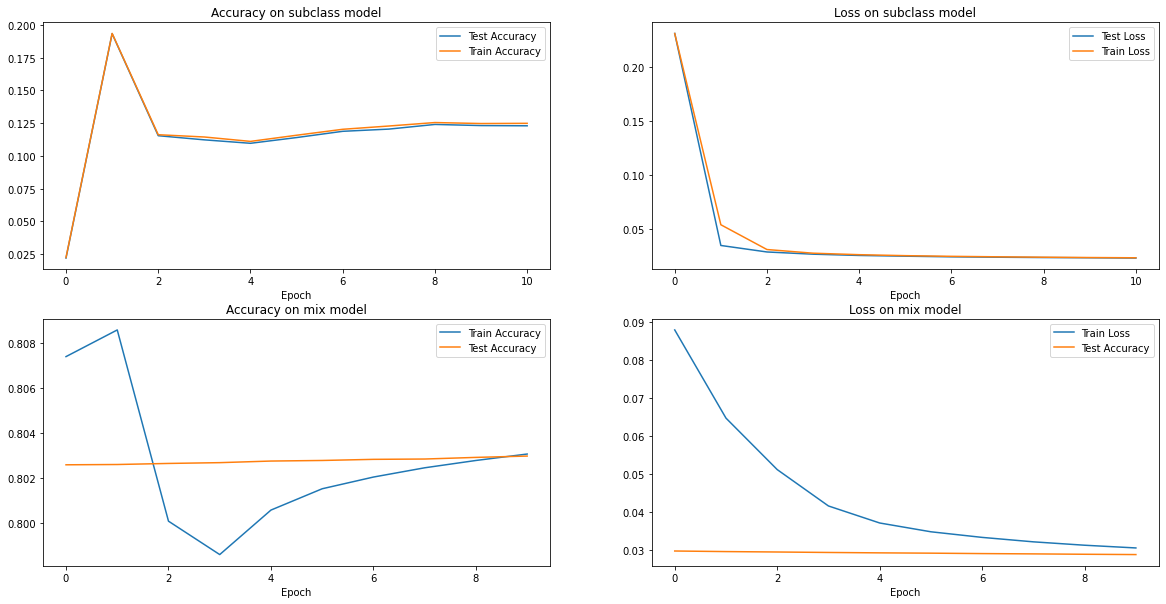

In [19]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(range(len(test_accuracies)),test_accuracies, label = 'Test Accuracy')
plt.plot(range(len(train_accuracies)),train_accuracies, label = 'Train Accuracy')
plt.legend()
plt.title('Accuracy on subclass model')
plt.xlabel('Epoch')

plt.subplot(2, 2, 2)
plt.plot(range(len(test_losses)),test_losses, label = 'Test Loss')
plt.plot(range(len(train_losses)),train_losses, label = 'Train Loss')
plt.legend()
plt.title('Loss on subclass model')
plt.xlabel('Epoch')

plt.subplot(2, 2, 3)
plt.plot(range(len(history1.history['accuracy'])),history1.history['accuracy'], label = 'Train Accuracy')
plt.plot(range(len(history2.history['accuracy'])),history2.history['accuracy'], label = 'Test Accuracy')
plt.legend()
plt.title('Accuracy on mix model')
plt.xlabel('Epoch')

plt.subplot(2, 2, 4)
plt.plot(range(len(history1.history['loss'])),history1.history['loss'], label = 'Train Loss')
plt.plot(range(len(history2.history['loss'])),history2.history['loss'], label = 'Test Accuracy')
plt.legend()
plt.title('Loss on mix model')
plt.xlabel('Epoch')

plt.show()


Again, the subclass model performed poorly, while the subclass-mix model performed well.

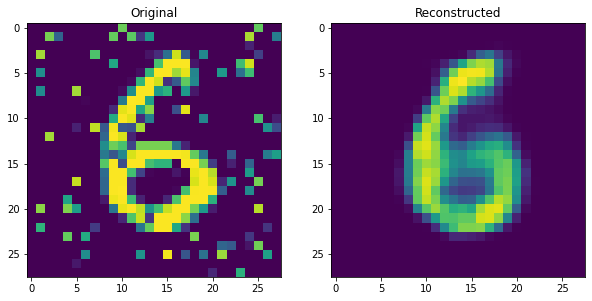

In [ ]:
sample = 106

original = add_noise(x_train[sample]/255.0)
new = tf.expand_dims(x_train[sample]/255.0, -1).numpy()
new = tf.expand_dims(new, 0)
reconstructed = ae.predict(new).reshape(28, 28)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed)
plt.title('Reconstructed')
plt.show()

For the number 6, we can see that the embeddings did a good job and the model predicted the digit correctly. The number 6 embedding is also faily isolated from the other numbers in the t-SNE plot.

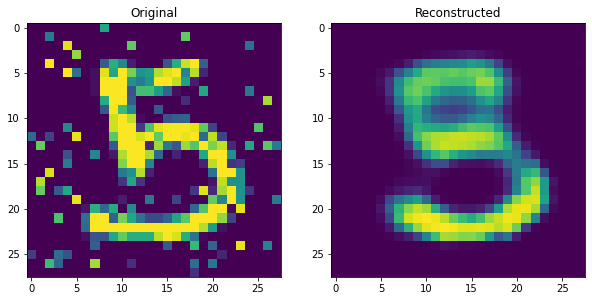

In [16]:
sample = 4845

original = add_noise(x_train[sample]/255.0)
new = tf.expand_dims(x_train[sample]/255.0, -1).numpy()
new = tf.expand_dims(new, 0)
reconstructed = ae.predict(new).reshape(28, 28)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed)
plt.title('Reconstructed')
plt.show()

For the number 5 however, it does not seem to correctly predict the digit from the embedding (the model predicted the digit 9 or 3). This is also reflected in the t-SNE plot.